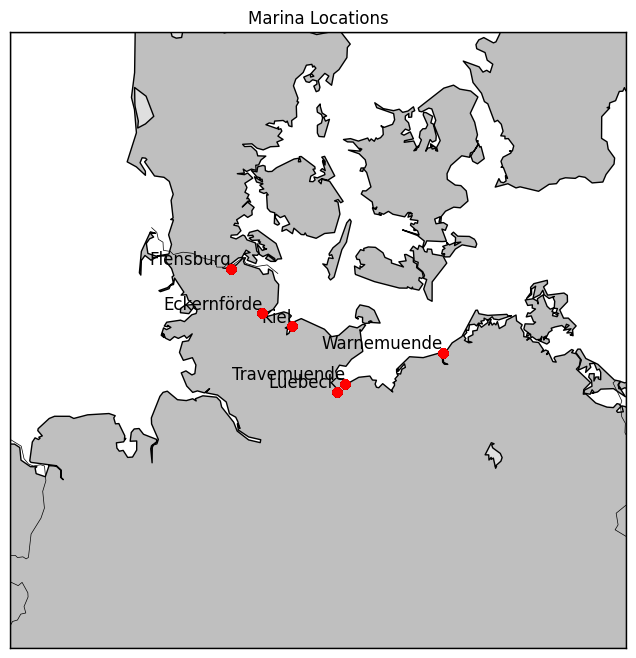

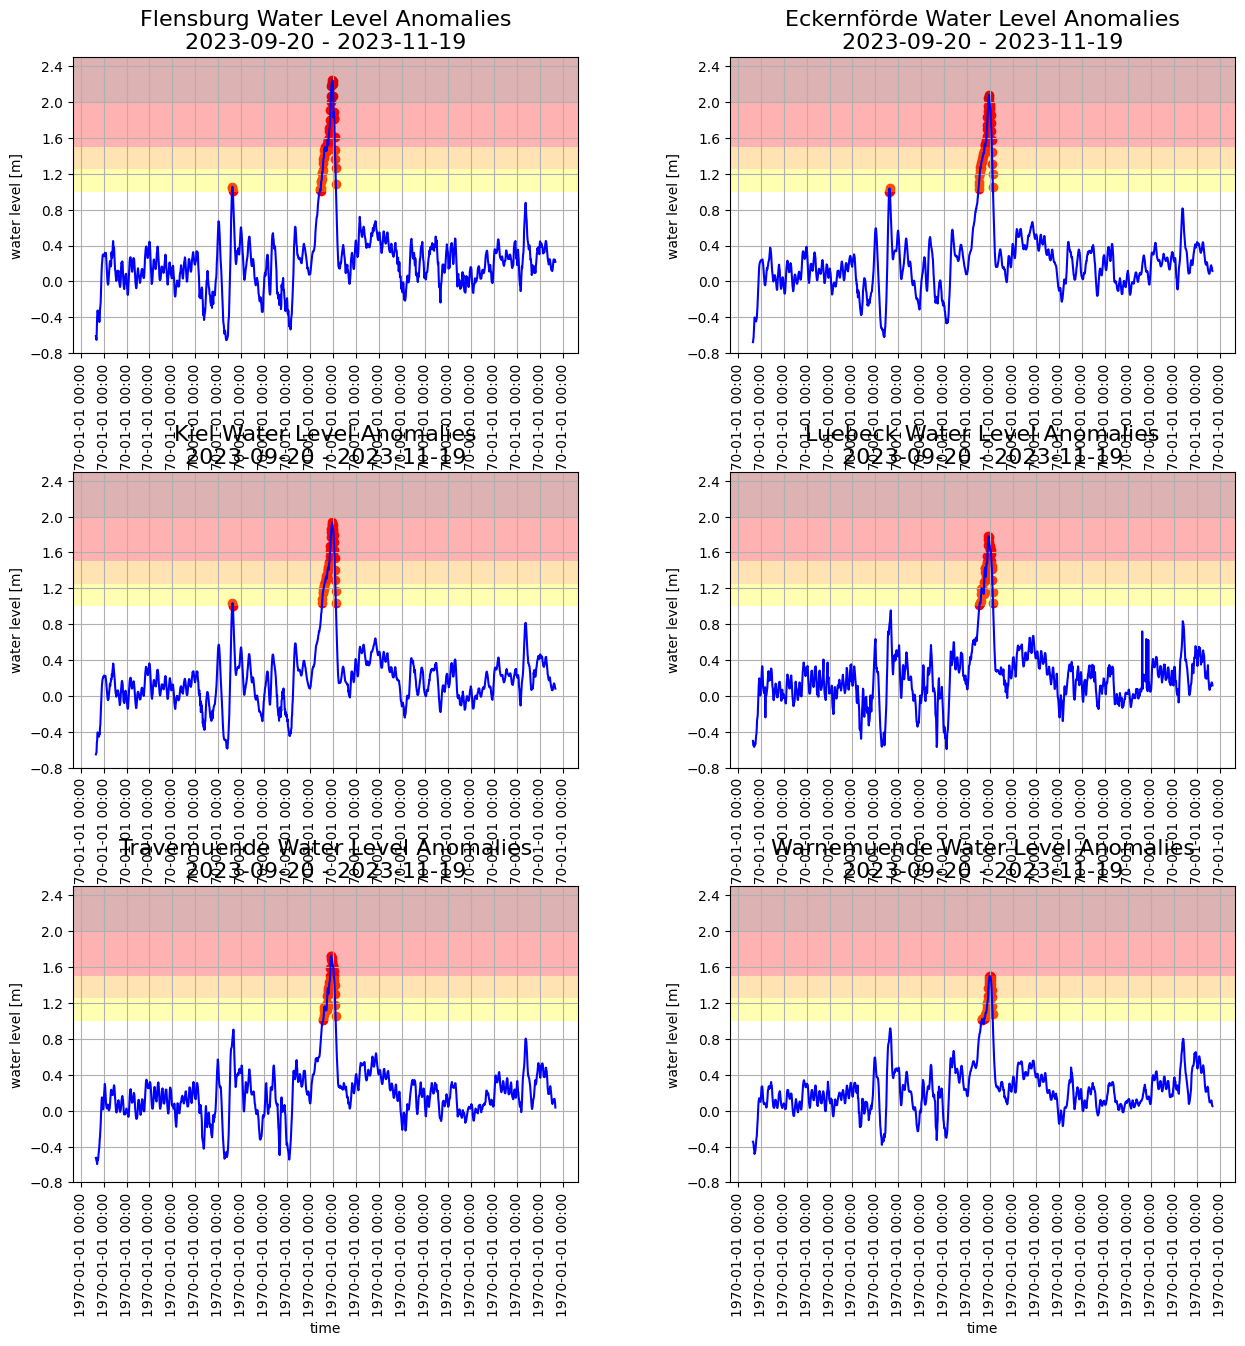

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap


from utils.eda_helper_functions import load_insitu_data, process_flensburg_data


def plot_water_level(df, marina_name, color='blue'):

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(df['time'], df['slev'], label='Water Level', color=color)
    ax.set_title(f'Water Level at {marina_name}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Water Level (m)')
    ax.legend()
    ax.grid()
    plt.show()

    return fig, ax


def plot_subplots(df_list, marina_names, colors):


    # Erstelle Figure und GridSpec
    fig = plt.figure(figsize=(15, 20))
    gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.4, wspace=0.3)


    # Erzeuge Subplots aus GridSpec
    for i, df in enumerate(df_list):
        row = i // 2
        col = i % 2
        ax = fig.add_subplot(gs[row, col])
        plot_water_level_anomalies(df, ax=ax, marina_name=marina_names[i])

    # Optional: leeres letztes Feld entfernen (wenn 7 von 8 Feldern belegt sind)
    if len(df_list) < 8:
        fig.delaxes(fig.add_subplot(gs[3, 1]))

    plt.show()



def plot_water_level_anomalies(df: pd.DataFrame, ax=None, anomaly_threshold: float = 1.0, start_date:str | None=None, end_date:str | None=None, marina_name=None) -> tuple[plt.Figure, plt.Axes]:
    """
    Plots water level time series with anomalies and categorized flood levels.

    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame containing columns 'time' (datetime) and 'slev' (water level in meters).
    anomaly_threshold : float, default=1.0
        Threshold above which water levels are considered anomalies (potential storm surges).

    Returns:
    -------
    None
        Displays a matplotlib plot.
    """

    
    df_anomalies = df.copy()
    

    if start_date or end_date:
        # Convert to datetime if not already
        df_anomalies['time'] = pd.to_datetime(df_anomalies['time'])

        # Filter the DataFrame based on the date range
        if start_date:
            df_anomalies = df_anomalies[df_anomalies['time'] >= start_date]
        if end_date:
            df_anomalies = df_anomalies[df_anomalies['time'] <= end_date]

    df_anomalies['anomaly'] = (df_anomalies['slev'] > anomaly_threshold).astype(int)

    # Group anomalies by time
    df_anomalies_grouped = (
        df_anomalies[df_anomalies['anomaly'] == 1]
        .groupby('time')[['slev']]
        .mean()
        .reset_index()
    )
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    # Plot water level line
    ax.plot(df_anomalies['time'], df_anomalies['slev'], label='water level', color='blue')

    # Plot anomalies as red dot
    ax.scatter(df_anomalies_grouped['time'], df_anomalies_grouped['slev'],
               color='red', label='anomaly', marker='o')

    # Highlight storm surge classes with colored bands
    flood_levels = [
        (1.0, 1.25, 'yellow', 'storm surge'),
        (1.25, 1.5, 'orange', 'medium storm surge'),
        (1.5, 2.0, 'red', 'heavy storm surge'),
        (2.0, 3.5, 'darkred', 'very heavy storm surge'),
    ]

    for y0, y1, color, label in flood_levels:
        ax.axhspan(y0, y1, facecolor=color, alpha=0.3, label=label)

    # Time range for title
    min_time = df_anomalies['time'].min().strftime('%Y-%m-%d')
    max_time = df_anomalies['time'].max().strftime('%Y-%m-%d')

    # Axis labeling and formatting
    ax.set_title(f"{marina_name} Water Level Anomalies\n{min_time} - {max_time}", fontsize=16)
    ax.set_xlabel("time")
    ax.set_ylabel("water level [m]")
    #ax.legend(loc='upper right')
    ax.set_ylim(-0.8, 2.5)  # Set y-axis limits
    ax.yaxis.set_major_locator(plt.MaxNLocator(10)) # make y-axis labels readable
    ax.xaxis.set_major_locator(plt.MaxNLocator(25)) # make x-axis labels readable
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y-%m-%d %H:%M')))
    # rotate x-axis labels for better readability
    ax.tick_params(axis='x', rotation=90)
    


    

    plt.grid(True)
    #plt.tight_layout()
    

    return ax

def plot_location_marina(df_list: pd.DataFrame, marina_names: list) -> tuple[plt.Figure, plt.Axes]:

    mean_lat = np.mean([df['latitude'].mean() for df in df_list])
    mean_lon = np.mean([df['longitude'].mean() for df in df_list])
    plt.figure(figsize=(10, 8))
    m = Basemap(
        projection="lcc",
        resolution="i",
        lat_0=mean_lat,
        lon_0=mean_lon,
        width=0.5e6,
        height=0.5e6,
    )

    m.drawcoastlines()
    m.drawcountries()
    m.drawmapboundary(fill_color='white')
    m.fillcontinents(color='grey', lake_color='white', alpha=0.5)

    for df in df_list:
        # Convert latitude and longitude to map projection coordinates
        x, y = m(df['longitude'].values, df['latitude'].values)
        m.scatter(x, y, marker='o', color='red', zorder=5)


    # Add labels for each marina
    for i, marina in enumerate(marina_names):
        x, y = m(df_list[i]['longitude'].values, df_list[i]['latitude'].values)
        plt.text(x[0], y[0], marina, fontsize=12, ha='right', va='bottom', color='black')
    plt.title('Marina Locations')
    plt.show()
    return None

    



def process_data(df:pd.DataFrame, start:pd.Timestamp, end:pd.Timestamp) -> pd.DataFrame:
    df['time'] = pd.to_datetime(df['time'])
    df = df.loc[(df['time'] >= start) & (df['time'] <= end)]
    df['slev'] = df['slev'].astype(float)

    df.set_index('time', inplace=True)
    df = df.resample('h').mean()
    df.reset_index(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df



def main():
    file_path = Path("../data/observation/")
    df_flensburg = load_insitu_data(file_name="NO_TS_TG_FlensburgTG.nc", file_path=file_path)
    df_flensburg = process_flensburg_data(df_flensburg).reset_index(drop=True)
    df_eckernfoerde = load_insitu_data(file_name="NO_TS_TG_EckernfoerdeTG.nc", file_path=file_path)
    df_kappeln = load_insitu_data(file_name="NO_TS_TG_KappelnTG.nc", file_path=file_path)
    df_kiel = load_insitu_data(file_name="NO_TS_TG_KielHoltenauTG.nc", file_path=file_path)
    df_luebeck = load_insitu_data(file_name="NO_TS_TG_LuebeckTG.nc", file_path=file_path)
    df_travemuende = load_insitu_data(file_name="NO_TS_TG_TravemuendeTG.nc", file_path=file_path)
    df_warnemuende = load_insitu_data(file_name="NO_TS_TG_WarnemuendeTG.nc", file_path=file_path)

    start_date = pd.Timestamp('2023-10-20') - pd.Timedelta(days=30)
    end_date = pd.Timestamp('2023-10-20') + pd.Timedelta(days=30)
    df_flensburg = process_data(df_flensburg, start_date, end_date)
    df_eckernfoerde = process_data(df_eckernfoerde, start_date, end_date)
    df_kappeln = process_data(df_kappeln, start_date, end_date)
    df_kiel = process_data(df_kiel, start_date, end_date)
    df_luebeck = process_data(df_luebeck, start_date, end_date)
    df_travemuende = process_data(df_travemuende, start_date, end_date)
    df_warnemuende = process_data(df_warnemuende, start_date, end_date)

    #print(df_flensburg.head())
   

    # Plotting all marinas in subplots
    marina_names = ['Flensburg','Eckernförde', 'Kiel', 'Luebeck', 'Travemuende', 'Warnemuende']
    df_list = [df_flensburg, df_eckernfoerde, df_kiel, df_luebeck, df_travemuende, df_warnemuende]
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']


    plot_location_marina(df_list, marina_names)
    plot_subplots(df_list, marina_names, colors)
    
    


if __name__ == '__main__':
    main()